In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import os
from torchmetrics.wrappers import MultioutputWrapper
import torchmetrics
from copy import deepcopy
import numpy as np
from qtaim_embed.models.utils import load_graph_level_model_from_config
from qtaim_embed.utils.tests import get_dataset_graph_level
from qtaim_embed.data.dataloader import DataLoaderMoleculeGraphTask
from qtaim_embed.utils.data import get_default_graph_level_config
from qtaim_embed.core.dataset import HeteroGraphGraphLabelDataset
from qtaim_embed.models.utils import get_test_train_preds_as_df, test_and_predict_libe
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping
import pytorch_lightning as pl

In [15]:
feat_dict_large = {
    "atom": [
        "extra_feat_atom_Lagrangian_K",
        "extra_feat_atom_Hamiltonian_K",
        "extra_feat_atom_e_density",
        "extra_feat_atom_lap_e_density",
        "extra_feat_atom_e_loc_func",
        "extra_feat_atom_ave_loc_ion_E",
        "extra_feat_atom_delta_g_promolecular",
        "extra_feat_atom_delta_g_hirsh",
        "extra_feat_atom_esp_nuc",
        "extra_feat_atom_esp_e",
        "extra_feat_atom_esp_total",
        "extra_feat_atom_grad_norm",
        "extra_feat_atom_lap_norm",
        "extra_feat_atom_eig_hess",
        "extra_feat_atom_det_hessian",
        "extra_feat_atom_ellip_e_dens",
        "extra_feat_atom_eta",
        "extra_feat_atom_energy_density",
        "extra_feat_atom_density_beta",
        "extra_feat_atom_density_alpha",
        "extra_feat_atom_spin_density",
        "extra_feat_atom_lol",
    ],
    "bond": [
        "bond_length",
        "extra_feat_bond_Lagrangian_K",
        "extra_feat_bond_Hamiltonian_K",
        "extra_feat_bond_e_density",
        "extra_feat_bond_lap_e_density",
        "extra_feat_bond_e_loc_func",
        "extra_feat_bond_ave_loc_ion_E",
        "extra_feat_bond_delta_g_promolecular",
        "extra_feat_bond_delta_g_hirsh",
        "extra_feat_bond_esp_nuc",
        "extra_feat_bond_esp_e",
        "extra_feat_bond_esp_total",
        "extra_feat_bond_grad_norm",
        "extra_feat_bond_lap_norm",
        "extra_feat_bond_eig_hess",
        "extra_feat_bond_det_hessian",
        "extra_feat_bond_ellip_e_dens",
        "extra_feat_bond_eta",
        "extra_feat_bond_energy_density",
        "extra_feat_bond_density_beta",
        "extra_feat_bond_density_alpha",
        "extra_feat_bond_spin_density",
        "extra_feat_bond_lol",
    ],
    "global": ["E1-CC2", "E2-CC2"],
}

feat_dict = {
    "atom": [],
    "bond": ["bond_length"],
    "global": ["E1-CC2", "E2-CC2"],
}


In [16]:
qm8_loc = "../../../../data/splits_1205/test_qm8_1205_large.pkl"
qm8_train_loc = "../../../../data/splits_1205/train_qm8_1205_small.pkl"

dataset_test_qtaim_small = HeteroGraphGraphLabelDataset(
    file=qm8_loc,
    allowed_ring_size=[4, 5, 6, 7],
    allowed_charges=None,
    allowed_spins=None,
    self_loop=True,
    extra_keys=feat_dict,
    target_list=["E1-CC2", "E2-CC2"],
    extra_dataset_info={},
    debug=False,
    log_scale_features=False,
    log_scale_targets=False,
    standard_scale_features=True,
    standard_scale_targets=True,
)
dataset_train_qtaim_small = HeteroGraphGraphLabelDataset(
    file=qm8_train_loc,
    allowed_ring_size=[4, 5, 6, 7],
    allowed_charges=None,
    allowed_spins=None,
    self_loop=True,
    extra_keys=feat_dict,
    target_list=["E1-CC2", "E2-CC2"],
    extra_dataset_info={},
    debug=False,
    log_scale_features=False,
    log_scale_targets=False,
    standard_scale_features=True,
    standard_scale_targets=True,
)

dataset_test_qtaim_large = HeteroGraphGraphLabelDataset(
    file=qm8_loc,
    allowed_ring_size=[4, 5, 6, 7],
    allowed_charges=None,
    allowed_spins=None,
    self_loop=True,
    extra_keys=feat_dict_large,
    target_list=["E1-CC2", "E2-CC2"],
    extra_dataset_info={},
    debug=False,
    log_scale_features=True,
    log_scale_targets=False,
    standard_scale_features=True,
    standard_scale_targets=True,
)
dataset_train_qtaim_large = HeteroGraphGraphLabelDataset(
    file=qm8_train_loc,
    allowed_ring_size=[4, 5, 6, 7],
    allowed_charges=None,
    allowed_spins=None,
    self_loop=True,
    extra_keys=feat_dict_large,
    target_list=["E1-CC2", "E2-CC2"],
    extra_dataset_info={},
    debug=False,
    log_scale_features=True,
    log_scale_targets=False,
    standard_scale_features=True,
    standard_scale_targets=True,
)


... > creating MoleculeWrapper objects


100%|██████████| 1927/1927 [00:00<00:00, 12188.83it/s]


... > bond_feats_error_count:  0
... > atom_feats_error_count:  0
element set {'F', 'O', 'N', 'C', 'H'}
selected atomic keys []
selected bond keys ['bond_length']
selected global keys ['E1-CC2', 'E2-CC2']
... > Building graphs and featurizing


100%|██████████| 1927/1927 [00:03<00:00, 610.82it/s]


included in labels
{'global': ['E1-CC2', 'E2-CC2']}
included in graph features
{'atom': ['total_degree', 'total_H', 'is_in_ring', 'ring_size_4', 'ring_size_5', 'ring_size_6', 'ring_size_7', 'chemical_symbol_F', 'chemical_symbol_O', 'chemical_symbol_N', 'chemical_symbol_C', 'chemical_symbol_H'], 'bond': ['metal bond', 'ring inclusion', 'ring size_4', 'ring size_5', 'ring size_6', 'ring size_7', 'bond_length'], 'global': ['num atoms', 'num bonds', 'molecule weight']}
original loader node types: dict_keys(['atom', 'bond', 'global'])
original loader label types: dict_keys([])
include names:  dict_keys(['global'])
... > parsing labels and features in graphs


100%|██████████| 1927/1927 [00:00<00:00, 34944.68it/s]


original loader node types: dict_keys(['atom', 'bond', 'global'])
original loader label types: dict_keys(['global'])
... > Scaling features
mean [1.39034979e+00 3.27400149e-01 3.73666584e-02 2.09935500e-02
 1.26209377e-02 3.10096750e-03 6.51203175e-04 7.13222525e-04
 7.43922104e-02 5.13210122e-02 3.41881667e-01 5.31691888e-01]
std [1.59284594 0.65438688 0.18965862 0.14336255 0.11163176 0.05559992
 0.02551037 0.0266967  0.2624081  0.22065168 0.47434017 0.49899461]
mean [0.00000000e+00 5.09465713e-02 2.86074884e-02 1.72065629e-02
 4.29112326e-03 8.83466554e-04 1.56831737e+00]
std [0.         0.21988865 0.16670063 0.13004037 0.06536597 0.02971003
 0.77385563]
Standard deviation for feature 0 is 0.0, smaller than 0.001. You may want to exclude this feature.
mean [ 16.73482097  12.33523612 109.86226376]
std [2.39501878 1.54996986 6.28249644]
... > Scaling features complete
... > feature mean(s): 
 {'atom': tensor([1.3903e+00, 3.2740e-01, 3.7367e-02, 2.0994e-02, 1.2621e-02, 3.1010e-03,
     

100%|██████████| 2061/2061 [00:00<00:00, 13390.93it/s]


... > bond_feats_error_count:  0
... > atom_feats_error_count:  0
element set {'F', 'O', 'N', 'C', 'H'}
selected atomic keys []
selected bond keys ['bond_length']
selected global keys ['E1-CC2', 'E2-CC2']
... > Building graphs and featurizing


100%|██████████| 2061/2061 [00:03<00:00, 647.02it/s]


included in labels
{'global': ['E1-CC2', 'E2-CC2']}
included in graph features
{'atom': ['total_degree', 'total_H', 'is_in_ring', 'ring_size_4', 'ring_size_5', 'ring_size_6', 'ring_size_7', 'chemical_symbol_F', 'chemical_symbol_O', 'chemical_symbol_N', 'chemical_symbol_C', 'chemical_symbol_H'], 'bond': ['metal bond', 'ring inclusion', 'ring size_4', 'ring size_5', 'ring size_6', 'ring size_7', 'bond_length'], 'global': ['num atoms', 'num bonds', 'molecule weight']}
original loader node types: dict_keys(['atom', 'bond', 'global'])
original loader label types: dict_keys([])
include names:  dict_keys(['global'])
... > parsing labels and features in graphs


100%|██████████| 2061/2061 [00:00<00:00, 33397.44it/s]


original loader node types: dict_keys(['atom', 'bond', 'global'])
original loader label types: dict_keys(['global'])
... > Scaling features
mean [1.65252819 0.26281712 0.12213707 0.0638654  0.04664376 0.01162791
 0.         0.01184813 0.12394292 0.17811839 0.34557787 0.34051268]
std [1.45628384 0.51187322 0.32744405 0.244513   0.21087466 0.10720401
 0.         0.10820238 0.32951642 0.38261238 0.47555631 0.47388163]
Standard deviation for feature 6 is 0.0, smaller than 0.001. You may want to exclude this feature.
mean [0.         0.1386109  0.07269106 0.0527757  0.01314414 0.
 1.41905218]
std [0.         0.34554004 0.25962872 0.22358539 0.11389192 0.
 0.74828357]
Standard deviation for feature 0 is 0.0, smaller than 0.001. You may want to exclude this feature.
Standard deviation for feature 5 is 0.0, smaller than 0.001. You may want to exclude this feature.
mean [ 11.01601164   9.74526929 101.31349282]
std [ 1.25622595  1.62274983 14.15565831]
... > Scaling features complete
... > featu

100%|██████████| 1927/1927 [00:00<00:00, 2469.54it/s]


... > bond_feats_error_count:  0
... > atom_feats_error_count:  0
element set {'F', 'O', 'N', 'C', 'H'}
selected atomic keys ['extra_feat_atom_Lagrangian_K', 'extra_feat_atom_Hamiltonian_K', 'extra_feat_atom_e_density', 'extra_feat_atom_lap_e_density', 'extra_feat_atom_e_loc_func', 'extra_feat_atom_ave_loc_ion_E', 'extra_feat_atom_delta_g_promolecular', 'extra_feat_atom_delta_g_hirsh', 'extra_feat_atom_esp_nuc', 'extra_feat_atom_esp_e', 'extra_feat_atom_esp_total', 'extra_feat_atom_grad_norm', 'extra_feat_atom_lap_norm', 'extra_feat_atom_eig_hess', 'extra_feat_atom_det_hessian', 'extra_feat_atom_ellip_e_dens', 'extra_feat_atom_eta', 'extra_feat_atom_energy_density', 'extra_feat_atom_density_beta', 'extra_feat_atom_density_alpha', 'extra_feat_atom_spin_density', 'extra_feat_atom_lol']
selected bond keys ['bond_length', 'extra_feat_bond_Lagrangian_K', 'extra_feat_bond_Hamiltonian_K', 'extra_feat_bond_e_density', 'extra_feat_bond_lap_e_density', 'extra_feat_bond_e_loc_func', 'extra_feat_b

100%|██████████| 1927/1927 [00:04<00:00, 438.83it/s]


included in labels
{'global': ['E1-CC2', 'E2-CC2']}
included in graph features
{'atom': ['total_degree', 'total_H', 'is_in_ring', 'ring_size_4', 'ring_size_5', 'ring_size_6', 'ring_size_7', 'chemical_symbol_F', 'chemical_symbol_O', 'chemical_symbol_N', 'chemical_symbol_C', 'chemical_symbol_H', 'extra_feat_atom_Lagrangian_K', 'extra_feat_atom_Hamiltonian_K', 'extra_feat_atom_e_density', 'extra_feat_atom_lap_e_density', 'extra_feat_atom_e_loc_func', 'extra_feat_atom_ave_loc_ion_E', 'extra_feat_atom_delta_g_promolecular', 'extra_feat_atom_delta_g_hirsh', 'extra_feat_atom_esp_nuc', 'extra_feat_atom_esp_e', 'extra_feat_atom_esp_total', 'extra_feat_atom_grad_norm', 'extra_feat_atom_lap_norm', 'extra_feat_atom_eig_hess', 'extra_feat_atom_det_hessian', 'extra_feat_atom_ellip_e_dens', 'extra_feat_atom_eta', 'extra_feat_atom_energy_density', 'extra_feat_atom_density_beta', 'extra_feat_atom_density_alpha', 'extra_feat_atom_spin_density', 'extra_feat_atom_lol'], 'bond': ['metal bond', 'ring inclus

100%|██████████| 1927/1927 [00:00<00:00, 34143.25it/s]


original loader node types: dict_keys(['atom', 'bond', 'global'])
original loader label types: dict_keys(['global'])
... > Log scaling features
... > Log scaling features complete
... > Scaling features
mean [ 6.84823520e-01  2.00907781e-01  2.59005940e-02  1.45516200e-02
  8.74816743e-03  2.14942689e-03  4.51379646e-04  4.94368184e-04
  5.15647510e-02  3.55730150e-02  2.36974314e-01  3.68540734e-01
  1.27377112e+00  7.02955112e+00 -7.02955112e+00 -8.35844906e+00
  6.93094419e-01  1.39064448e+00  8.03468377e-02  1.28234921e-01
  8.99833292e+00 -2.99835759e+00  8.82590194e+00  0.00000000e+00
 -8.35844906e+00 -8.35844906e+00 -2.17177520e+01  3.27659130e-04
 -7.17956420e-01 -7.02955112e+00  2.12943514e+00  2.12943514e+00
  0.00000000e+00  6.89706350e-01]
std [5.96139692e-01 3.69792652e-01 1.31461336e-01 9.93713479e-02
 7.73772394e-02 3.85389304e-02 1.76824429e-02 1.85047430e-02
 1.81887433e-01 1.52944093e-01 3.28787549e-01 3.45876710e-01
 1.45168288e+00 5.36993345e+00 5.36993345e+00 5.423

100%|██████████| 2061/2061 [00:00<00:00, 2784.34it/s]


... > bond_feats_error_count:  0
... > atom_feats_error_count:  0
element set {'F', 'O', 'N', 'C', 'H'}
selected atomic keys ['extra_feat_atom_Lagrangian_K', 'extra_feat_atom_Hamiltonian_K', 'extra_feat_atom_e_density', 'extra_feat_atom_lap_e_density', 'extra_feat_atom_e_loc_func', 'extra_feat_atom_ave_loc_ion_E', 'extra_feat_atom_delta_g_promolecular', 'extra_feat_atom_delta_g_hirsh', 'extra_feat_atom_esp_nuc', 'extra_feat_atom_esp_e', 'extra_feat_atom_esp_total', 'extra_feat_atom_grad_norm', 'extra_feat_atom_lap_norm', 'extra_feat_atom_eig_hess', 'extra_feat_atom_det_hessian', 'extra_feat_atom_ellip_e_dens', 'extra_feat_atom_eta', 'extra_feat_atom_energy_density', 'extra_feat_atom_density_beta', 'extra_feat_atom_density_alpha', 'extra_feat_atom_spin_density', 'extra_feat_atom_lol']
selected bond keys ['bond_length', 'extra_feat_bond_Lagrangian_K', 'extra_feat_bond_Hamiltonian_K', 'extra_feat_bond_e_density', 'extra_feat_bond_lap_e_density', 'extra_feat_bond_e_loc_func', 'extra_feat_b

100%|██████████| 2061/2061 [00:04<00:00, 463.72it/s]


included in labels
{'global': ['E1-CC2', 'E2-CC2']}
included in graph features
{'atom': ['total_degree', 'total_H', 'is_in_ring', 'ring_size_4', 'ring_size_5', 'ring_size_6', 'ring_size_7', 'chemical_symbol_F', 'chemical_symbol_O', 'chemical_symbol_N', 'chemical_symbol_C', 'chemical_symbol_H', 'extra_feat_atom_Lagrangian_K', 'extra_feat_atom_Hamiltonian_K', 'extra_feat_atom_e_density', 'extra_feat_atom_lap_e_density', 'extra_feat_atom_e_loc_func', 'extra_feat_atom_ave_loc_ion_E', 'extra_feat_atom_delta_g_promolecular', 'extra_feat_atom_delta_g_hirsh', 'extra_feat_atom_esp_nuc', 'extra_feat_atom_esp_e', 'extra_feat_atom_esp_total', 'extra_feat_atom_grad_norm', 'extra_feat_atom_lap_norm', 'extra_feat_atom_eig_hess', 'extra_feat_atom_det_hessian', 'extra_feat_atom_ellip_e_dens', 'extra_feat_atom_eta', 'extra_feat_atom_energy_density', 'extra_feat_atom_density_beta', 'extra_feat_atom_density_alpha', 'extra_feat_atom_spin_density', 'extra_feat_atom_lol'], 'bond': ['metal bond', 'ring inclus

100%|██████████| 2061/2061 [00:00<00:00, 33937.38it/s]


original loader node types: dict_keys(['atom', 'bond', 'global'])
original loader label types: dict_keys(['global'])
... > Log scaling features
... > Log scaling features complete
... > Scaling features
mean [ 8.27789771e-01  1.73023082e-01  8.46589648e-02  4.42681208e-02
  3.23309931e-02  8.05985096e-03  0.00000000e+00  8.21249965e-03
  8.59106841e-02  1.23462262e-01  2.39536328e-01  2.36025408e-01
  1.97560977e+00  9.21639144e+00 -9.21639144e+00 -1.05651528e+01
  6.93099843e-01  1.86192282e+00  7.45801237e-02  1.16057638e-01
  1.08716512e+01 -3.11059573e+00  1.07602161e+01  0.00000000e+00
 -1.05651528e+01 -1.05651528e+01 -2.83588846e+01  3.87329401e-04
 -7.12087567e-01 -9.21639144e+00  3.00015019e+00  3.00015019e+00
  0.00000000e+00  6.90367730e-01]
std [5.51280917e-01 3.22074198e-01 2.26966920e-01 1.69483500e-01
 1.46167177e-01 7.43081542e-02 0.00000000e+00 7.50001723e-02
 2.28403378e-01 2.65206691e-01 3.29630518e-01 3.28469715e-01
 1.57482956e+00 5.22108741e+00 5.22108741e+00 5.273

In [17]:
best_model_noqtaim = {
    "atom_feature_size": 12,
    "bond_feature_size": 7,
    "global_feature_size": 3,
    "conv_fn": "GraphConvDropoutBatch",
    "target_dict": {"global": ["E1-CC2", "E2-CC2"]},
    "dropout": 0.2,
    "batch_norm_tf": True,
    "activation": "ReLU",
    "bias": True,
    "norm": "both",
    "aggregate": "sum",
    "n_conv_layers": 3,
    "lr": 0.013564488026117531,
    "weight_decay": 1e-05,
    "lr_plateau_patience": 25,
    "lr_scale_factor": 0.5,
    "scheduler_name": "reduce_on_plateau",
    "loss_fn": "mse",
    "resid_n_graph_convs": 2,
    "embedding_size": 16,
    "fc_layer_size": [512, 512],
    "fc_dropout": 0.1,
    "fc_batch_norm": True,
    "n_fc_layers": 2,
    "global_pooling_fn": "WeightAndSumThenCat",
    "ntypes_pool": ["atom", "bond", "global"],
    "ntypes_pool_direct_cat": ["global"],
    "lstm_iters": 15,
    "lstm_layers": 2,
    "num_heads": 2,
    "feat_drop": 0.1,
    "attn_drop": 0.1,
    "residual": False,
    "hidden_size": 10,
    "ntasks": 2,
    "num_heads_gat": 2,
    "dropout_feat_gat": 0.1,
    "dropout_attn_gat": 0.1,
    "hidden_size_gat": 10,
    "residual_gat": False,
    "batch_norm": True,
    "pooling_ntypes": ["atom", "bond", "global"],
    "pooling_ntypes_direct": ["global"],
    "restore": False,
    "classifier": False,
    "shape_fc": "flat",
    "fc_hidden_size_1": 1024,
    "fc_num_layers": 3,
}

best_model_qtaim = {
    "atom_feature_size": 34,
    "bond_feature_size": 29,
    "global_feature_size": 3,
    "conv_fn": "ResidualBlock",
    "target_dict": {"global": ["E1-CC2", "E2-CC2"]},
    "dropout": 0.2,
    "batch_norm_tf": False,
    "activation": "ReLU",
    "bias": True,
    "norm": "both",
    "aggregate": "sum",
    "n_conv_layers": 4,
    "lr": 0.044,
    "weight_decay": 0.000005,
    "lr_plateau_patience": 10,
    "lr_scale_factor": 0.5,
    "scheduler_name": "reduce_on_plateau",
    "loss_fn": "mse",
    "resid_n_graph_convs": 2,
    "embedding_size": 80,
    "fc_layer_size": [512, 512],
    "fc_dropout": 0.1,
    "fc_batch_norm": True,
    "n_fc_layers": 2,
    "global_pooling_fn": "MeanPoolingThenCat",
    "ntypes_pool": ["atom", "bond", "global"],
    "ntypes_pool_direct_cat": ["global"],
    "lstm_iters": 15,
    "lstm_layers": 2,
    "num_heads": 3,
    "feat_drop": 0.2,
    "attn_drop": 0.1,
    "residual": False,
    "hidden_size": 64,
    "ntasks": 2,
    "num_heads_gat": 1,
    "dropout_feat_gat": 0.1,
    "dropout_attn_gat": 0.1,
    "hidden_size_gat": 8,
    "residual_gat": True,
    "batch_norm": True,
    "pooling_ntypes": ["atom", "bond", "global"],
    "pooling_ntypes_direct": ["global"],
    "shape_fc": "flat",
    "restore": False,
    "classifier": False,
    "fc_hidden_size_1": 512,
    "fc_num_layers": 2,
}


In [18]:
model_temp = load_graph_level_model_from_config(best_model_qtaim)

dataloader_train = DataLoaderMoleculeGraphTask(
    dataset_train_qtaim_large, batch_size=256, shuffle=True, num_workers=0
)
dataloader_test = DataLoaderMoleculeGraphTask(
    dataset_test_qtaim_large,
    batch_size=len(dataset_test_qtaim_large.graphs),
    shuffle=False,
    num_workers=0,
)
early_stopping_callback = EarlyStopping(
    monitor="val_mae", min_delta=0.00, patience=100, verbose=False, mode="min"
)

lr_monitor = LearningRateMonitor(logging_interval="step")

trainer = pl.Trainer(
    max_epochs=1000,
    accelerator="gpu",
    gradient_clip_val=1.0,
    devices=1,
    accumulate_grad_batches=1,
    enable_progress_bar=True,
    callbacks=[
        early_stopping_callback,
        lr_monitor,
    ],
    enable_checkpointing=True,
    check_val_every_n_epoch=1,
    strategy="auto",
    # default_root_dir=model_save_string,
    default_root_dir="./test/",
    precision="bf16-mixed",
)


trainer.fit(model_temp, dataloader_train)
trainer.save_checkpoint(f"./qm8_big_small_manual_qtaim.ckpt")


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/santiagovargas/anaconda3/envs/qtaim_embed/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:71: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type               | Params
--------------------------------------------------------
0  | activation      | ReLU               | 0     
1  | embedding       | UnifySize          | 5.3 K 
2  | conv_layers     | ModuleList         | 219 K 
3  | readout         | MeanPoolingThenCat | 0     
4  | loss            | ModuleList         | 0     
5  | fc_layers       | ModuleList         | 349 K 
6  | train_r2        | MultioutputWrapper | 0     
7  | train_torch_l1  | MultioutputWra

:::REGRESSION MODEL:::
readout in size 162
... > number of tasks: 2


/home/santiagovargas/anaconda3/envs/qtaim_embed/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/santiagovargas/anaconda3/envs/qtaim_embed/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Epoch 00012: reducing learning rate of group 0 to 2.2000e-02.
Epoch 00023: reducing learning rate of group 0 to 1.1000e-02.
Epoch 00034: reducing learning rate of group 0 to 5.5000e-03.
Epoch 00045: reducing learning rate of group 0 to 2.7500e-03.
Epoch 00056: reducing learning rate of group 0 to 1.3750e-03.
Epoch 00067: reducing learning rate of group 0 to 6.8750e-04.
Epoch 00078: reducing learning rate of group 0 to 3.4375e-04.
Epoch 00089: reducing learning rate of group 0 to 1.7187e-04.
Epoch 00100: reducing learning rate of group 0 to 8.5937e-05.


r2 tensor([0.4505, 0.2874])
mae tensor([0.0256, 0.0274])
mse tensor([0.0327, 0.0352])


Text(0.5, 0.98, 'QTAIM-Embed(QTAIM) QM8 OOD Test')

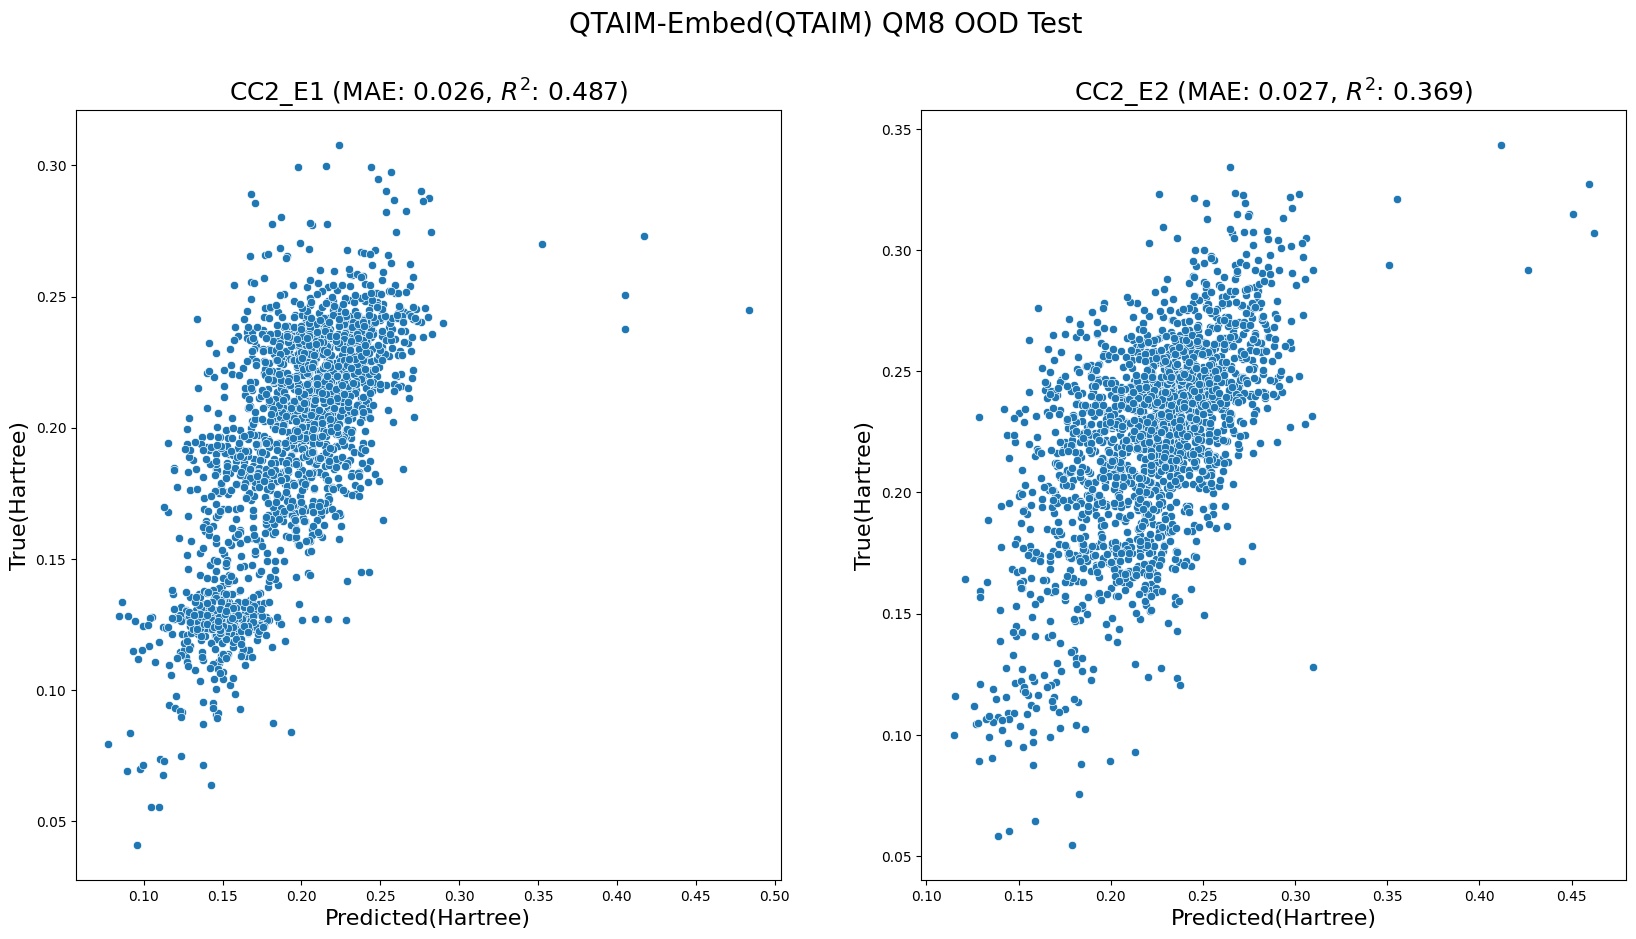

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

model_temp.cpu()
batch_graph, batched_labels = next(iter(dataloader_test))
r2_pre, mae, mse, preds_unscaled, labels_unscaled = model_temp.evaluate_manually(
    batch_graph,
    batched_labels,
    scaler_list=dataset_train_qtaim_large.label_scalers,
)


print("r2", r2_pre)
print("mae", mae)
print("mse", mse)


# plot the results
# sns.set_context("talk")
# sns.set_style("white")
# sns.set_palette("colorblind")

name_list = ["CC2_E1", "CC2_E2"]

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for i in range(2):
    key = name_list[i]
    sns.scatterplot(x=preds_unscaled[:, i], y=labels_unscaled[:, i], ax=ax[i])
    mae = np.abs(
        preds_unscaled[:, i].detach().numpy() - labels_unscaled[:, i].detach().numpy()
    )
    mae = np.mean(mae)
    r2 = (
        np.corrcoef(np.array(preds_unscaled[:, i]), np.array(labels_unscaled[:, i]))[
            1, 0
        ]
        ** 2
    )

    ax[i].set_title(
        "{} (MAE: {:.3f}, $R^2$: {:.3f})".format(
            key,
            mae,
            r2,
        ), fontsize=18
    )
    ax[i].set_xlabel("Predicted(Hartree)", fontsize=16)
    ax[i].set_ylabel("True(Hartree)", fontsize=16)
fig.suptitle("QTAIM-Embed(QTAIM) QM8 OOD Test", fontsize=20)

# r2 tensor([0.4258, 0.2731])
# mae tensor([0.0258, 0.0280])
# mse tensor([0.0334, 0.0355])


In [35]:
# no qtaim


In [20]:
model_temp = load_graph_level_model_from_config(best_model_noqtaim)

dataloader_train = DataLoaderMoleculeGraphTask(
    dataset_train_qtaim_small, batch_size=256, shuffle=True, num_workers=0
)
dataloader_test = DataLoaderMoleculeGraphTask(
    dataset_test_qtaim_small,
    batch_size=len(dataset_test_qtaim_small.graphs),
    shuffle=False,
    num_workers=0,
)
early_stopping_callback = EarlyStopping(
    monitor="val_mae", min_delta=0.00, patience=100, verbose=False, mode="min"
)

lr_monitor = LearningRateMonitor(logging_interval="step")

trainer = pl.Trainer(
    max_epochs=1000,
    accelerator="gpu",
    gradient_clip_val=1.0,
    devices=1,
    accumulate_grad_batches=1,
    enable_progress_bar=True,
    callbacks=[
        early_stopping_callback,
        lr_monitor,
    ],
    enable_checkpointing=True,
    check_val_every_n_epoch=1,
    strategy="auto",
    # default_root_dir=model_save_string,
    default_root_dir="./test/",
    precision="32",
)


trainer.fit(model_temp, dataloader_train)
trainer.save_checkpoint(f"./qm8_big_small_manual_noqtaim.ckpt")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/santiagovargas/anaconda3/envs/qtaim_embed/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:71: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params
---------------------------------------------------------
0  | activation      | ReLU                | 0     
1  | embedding       | UnifySize           | 352   
2  | conv_layers     | ModuleList          | 8.2 K 
3  | readout         | WeightAndSumThenCat | 34    
4  | loss            | ModuleList          | 0     
5  | fc_layers       | ModuleList          | 2.2 M 
6  | train_r2        | MultioutputWrapper  | 0     
7  | train_torch_l1  | MultioutputWrapper  | 0     
8  | train_torch_mse | 

:::REGRESSION MODEL:::
readout in size 48
... > number of tasks: 2


/home/santiagovargas/anaconda3/envs/qtaim_embed/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/santiagovargas/anaconda3/envs/qtaim_embed/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Epoch 00027: reducing learning rate of group 0 to 6.7822e-03.
Epoch 00053: reducing learning rate of group 0 to 3.3911e-03.
Epoch 00079: reducing learning rate of group 0 to 1.6956e-03.


r2 tensor([-0.0471,  0.1308])
mae tensor([0.0333, 0.0291])
mse tensor([0.0451, 0.0388])


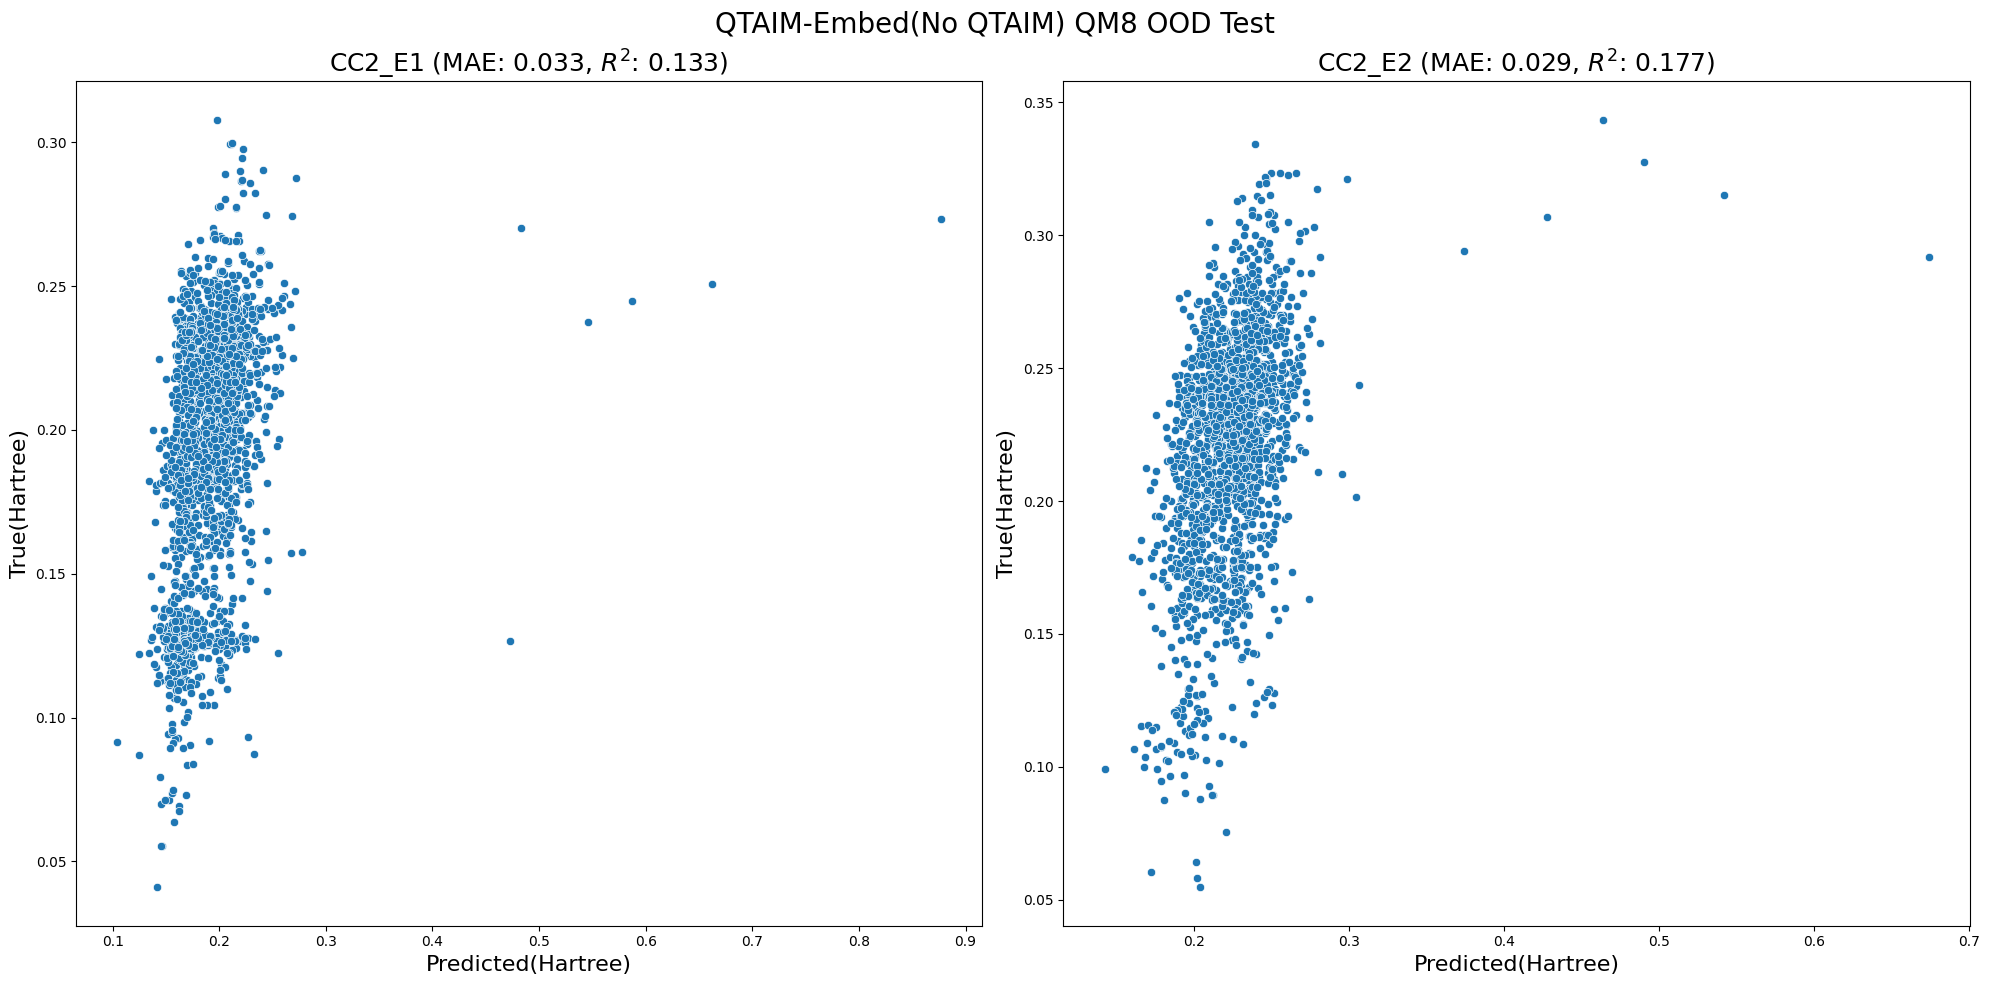

In [23]:

model_temp.cpu()
batch_graph, batched_labels = next(iter(dataloader_test))
r2_pre, mae, mse, preds_unscaled, labels_unscaled = model_temp.evaluate_manually(
    batch_graph,
    batched_labels,
    scaler_list=dataset_train_qtaim_small.label_scalers,
)


print("r2", r2_pre)
print("mae", mae)
print("mse", mse)


# plot the results
# sns.set_context("talk")
# sns.set_style("white")
# sns.set_palette("colorblind")

name_list = ["CC2_E1", "CC2_E2"]

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for i in range(2):
    key = name_list[i]
    sns.scatterplot(x=preds_unscaled[:, i], y=labels_unscaled[:, i], ax=ax[i])
    mae = np.abs(
        preds_unscaled[:, i].detach().numpy() - labels_unscaled[:, i].detach().numpy()
    )
    mae = np.mean(mae)
    r2 = (
        np.corrcoef(np.array(preds_unscaled[:, i]), np.array(labels_unscaled[:, i]))[
            1, 0
        ]
        ** 2
    )

    ax[i].set_title(
        "{} (MAE: {:.3f}, $R^2$: {:.3f})".format(
            key,
            mae,
            r2,
        ), fontsize=18
    )
    ax[i].set_xlabel("Predicted(Hartree)", fontsize=16)
    ax[i].set_ylabel("True(Hartree)", fontsize=16)
    # ax[i].set_xlim(0.0, 0.4)
    # ax[i].set_ylim(0.0, 0.4)
fig.suptitle("QTAIM-Embed(No QTAIM) QM8 OOD Test", fontsize=20)
fig.tight_layout()
